# Uma breve introdução à inferência Bayesiana

<TABLE>
<tr>
    <th><img src="imgs_prez/betao-1X.jpg"  width="128" height="128" align="center"/></th>
    <th align="center">Roberto Pereira Silveira</th>
</tr>
</TABLE>

In [1]:
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

import arviz as az
az.style.use("arviz-darkgrid")

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline  

/Users/rsilvei/Envs/bayesian/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## TOC:
* [1 - 3 Steps of Bayesian Data Analises](#3steps-BDA)
* [2 - Bayes Formula - An Intuition](#bayes-formula)
* [3 - Most Used Distributions](#distributions)
* [4 - Posterior Approximation - A glimpse into MCMC](#mcmc)
* [5 - Quick Example in PyMC3](#example)
* [6 - Sources](#sources)

## 1. The three steps of Bayesian data analysis (Gelman) <a class="anchor" id="3steps-BDA"></a>

#### Frequentist Approach

- Need robust calibration


#### Bayesian Inference
- Model not only frequency but also epistemological variation and weights over the model configuration space  
- A probability distribution encodes much more information than a step function!

 - **Prior** = prior distribution encodes domain expertise about the model configurations in the observational model, and possibly even the context of the observational model relative to the true data generating process and latent observational process  
  - prior distributions do not need to encode all of our domain expertise but rather just enough to ensure useful inferences  
 - **Likelihood** = The likelihood function maps each model configuration to a numerical quantification that increases for model configurations that are more consistent with the specific observation and decreases for those model configurations that are less consistent. In other words, the likelihood function quantifies the relative consistency of each model configuration with the observed data.  
 - **Posterior** = Bayes’ Theorem can be thought of as switching from one conditional probability density function, that specifying the observational model, to another, that specifying the posterior distribution.


**Contraction** $\rightarrow$ likelihood function is more informative than, but also consistent with, the prior distribution:

 <img src="imgs_prez/img7.png" width="640" height="640" align="center"/>
 **Source**: betanalpha.github.io

**Containment** $\rightarrow$ prior distribution is more informative than, but also consistent with, the likelihood function:

 <img src="imgs_prez/img8.png" width="640" height="640" align="center"/>
 **Source**: betanalpha.github.io

**Compromise** $\rightarrow$ when there is tension between the information encoded in the likelihood function and the prior:

 <img src="imgs_prez/img9.png" width="640" height="640" align="center"/>
 **Source**: betanalpha.github.io

 <img src="imgs_prez/img1.png" align="center"/>
 **Source**: betanalpha.github.io

 <img src="imgs_prez/img2.png" align="center"/>
 
 **Source**: betanalpha.github.io

<img src="imgs_prez/img3.png" align="center"/>

 **Source**: betanalpha.github.io

<img src="imgs_prez/img4.png" align="center"/>

 **Source**: betanalpha.github.io

<img src="imgs_prez/img5.png" align="center"/>

 **Source**: betanalpha.github.io

<img src="imgs_prez/img6.png" align="center"/>

 **Source**: betanalpha.github.io

## 2. Bayes Formula - An Intuition <a class="anchor" id="bayes-formula"></a>

From product rule we have

$$
p(\theta,  y)= p(\theta \mid y) \: p(y) 
$$

Can be also written as:
$$
p(\theta,  y)= p(y \mid \theta ) \: p(\theta)
$$

Re-ordening
$$
p(\theta \mid y) \: p(y) = p(y \mid \theta ) \: p(\theta)
$$

Finally:
$$
p(\theta \mid y)  = \frac{p(y \mid \theta ) \: p(\theta)}{p(y)}
$$

Where:
    
$p(y \mid \theta ) \rightarrow$ **Likelihood** ="plausibility"of the data given the parameters  

$p(\theta)  \rightarrow$ **Prior Distribution** = What we know about parameters withouth seen the data 

$p(y) \rightarrow $  **Marginal Likelihood or Evidence** = Normalizing constant (so that posterior probabilities sum to 1)

$(\theta \mid y) \rightarrow $  **Posterior Distribution** = compromise between prior and likelihood, updating prior believes in light of new data $\rightarrow$ suitable for **sequential** data analysis  

Writting differently ($ \theta = hypothesis $, $ y = data $):   
$$
p(hypothesis \mid data)  = \frac{p(data \mid hypothesis ) \: p(hypothesis)}{p(data)}
$$

### _"A Bayesian us one who, vagely expecting a horse, and catching a glimpse of a donkey, strongly believes he has seen a mule."_

## A quick Example
 **Source**: https://github.com/AllenDowney/BiteSizeBayes/blob/master/05_test_soln.ipynb

> In Bayesville, 1% of the population has an undiagnosed medical condition.  Jimmy gets tested for the condition and the test comes back positive; that is, the test says Jimmy has the condition.  
>
> The test is 95% accurate, which means
>
> * If you give the test to someone with the condition, the probability is 95% that the test will be positive, and 
>
> * If you give it to someone who does not have the condition, the probability is 95% that the test will be negative.
>
> What is the probability that Jimmy actually has the condition?  

Because the test is 95% accurate, it is tempting to say that the probability is 95% that the test is correct and Jimmy has the condition.

In [2]:
import pandas as pd

table = pd.DataFrame(index=['condition', 'no condition'])
table['prior'] = 0.01, 0.99
table

,prior
condition,0.01
no condition,0.99


In [3]:
table['likelihood'] = 0.95, 0.05
table

,prior,likelihood
condition,0.01,0.95
no condition,0.99,0.05


In [4]:
table['unnorm'] = table['prior'] * table['likelihood']
table

,prior,likelihood,unnorm
condition,0.01,0.95,0.0095
no condition,0.99,0.05,0.0495


In [5]:
prob_data = table['unnorm'].sum()
prob_data

0.059000000000000004

In [6]:
table['posterior'] = table['unnorm'] / prob_data
table

,prior,likelihood,unnorm,posterior
condition,0.01,0.95,0.0095,0.161017
no condition,0.99,0.05,0.0495,0.838983


In [7]:
def make_bayes_table(hypos, prior, likelihood):
    """Make a Bayes table.
    
    hypos: sequence of hypotheses
    prior: prior probabilities
    likelihood: sequence of likelihoods
    
    returns: DataFrame
    """
    table = pd.DataFrame(index=hypos)
    table['prior'] = prior
    table['likelihood'] = likelihood
    table['unnorm'] = table['prior'] * table['likelihood']
    prob_data = table['unnorm'].sum()
    table['posterior'] = table['unnorm'] / prob_data
    return table

In [9]:
## Increased Test Sensitivity to 99.5%
hypos = ['condition', 'no condition']
prior = 0.01, 0.99
likelihood = 0.995, 0.005

make_bayes_table(hypos, prior, likelihood)

,prior,likelihood,unnorm,posterior
condition,0.01,0.995,0.00995,0.667785
no condition,0.99,0.005,0.00495,0.332215


In [10]:
## Re-Test, Again Positive
hypos = ['condition', 'no condition']
prior = 0.667785, 0.332215
likelihood = 0.995, 0.005

make_bayes_table(hypos, prior, likelihood)

,prior,likelihood,unnorm,posterior
condition,0.667785,0.995,0.664446,0.997506
no condition,0.332215,0.005,0.001661,0.002494


<img src="imgs_prez/bayesian_inference_summary.png" width="640" height="640" align="center"/>

**Source**: Osvaldo Martin - Bayesian Analysis with Python

## 3. Most Used Distributions <a class="anchor" id="distributions"></a>


3.1. **Continuous Distributions** <a class="anchor" id="continuous"></a>  
3.1.1 - Uniform  
3.1.2 - Normal (Gaussian) <a class="anchor" id="normal"></a>  
3.1.3 - T-Student (Robust Inference) <a class="anchor" id="tstudent"></a>  
3.1.4 - Beta (univariate)  <a class="anchor" id="beta"></a>  
3.1.5 - Gamma  <a class="anchor" id="gamma"></a>  

3.2. **Discrete Distributions**  
3.2.1 - Bernouli  
3.2.2 - Binomial  
3.2.3 - Poisson  
3.2.4 - Negative Binomial  

#### https://pymc3.readthedocs.io/en/latest/api/distributions/continuous.html

In [ ]:
def get_samples(dist, n_samples):
    samples = np.array([dist.random() for n in range(n_samples)])
    return samples

In [ ]:
def plot_dist_kde(dist, n_samples):
    samples = np.array([dist.random() for n in range(n_samples)])
    return None

## 3.1 Continuous Distributions <a class="anchor" id="continuous-distributions"></a>

### 3.1.1 - Uniform Distribution

$$
p(x \mid lower, upper) = \frac{1}{upper-lower}
$$

In [ ]:
x = np.linspace(-3.0, 3.0, 1000)
a, b = 0.0, 2.0
y = np.zeros(1000)
y[(x<b) & (x>a)] = 1.0/(b-a)
fig, ax = plt.subplots(figsize=(20,12))
ax.plot(x, y, label='lower=1, upper=2', linewidth=4)
a, b = -2.0, 1.0
y = np.zeros(1000)
y[(x<b) & (x>a)] = 1.0/(b-a)
ax.plot(x, y, label='lower=-2, upper=1', linewidth=4)
ax.legend(loc='upper left', frameon=True, shadow=True, fontsize = 'xx-large')
ax.set(ylim=[-0.1,0.6], xlabel='x', ylabel='p(x | lower, upper)')
plt.show()

### 3.1.2 - Normal (Gaussian) Distribution

$$
p(x \mid \mu, \sigma) = \frac{1}{\sigma \sqrt{2\pi}} e^{\frac{-1}{2}(\frac{x-\mu}{\sigma})^2}
$$

In [ ]:
x = np.linspace(-5.0, 5.0, 1000)
fig, ax = plt.subplots(figsize=(20,12))
f = lambda mu, sd : st.norm.pdf(x, loc=mu, scale=sd)
plot_pdf = lambda a, b : ax.plot(x, f(a,b), label=r'$\mu$={0}, $\sigma$={1}'.format(a,b), linewidth=4)
plot_pdf(0.0, 0.4)
plot_pdf(0.0, 1.0)
plot_pdf(0.0, 2.0)
plot_pdf(-2.0, 0.4)
plt.legend(loc='upper left', frameon=True, shadow=True, fontsize = 'xx-large')
ax.set(xlim=[-5,5], ylim=[-0.05,1.1], xlabel='x', ylabel='p(x | μ,σ)')
plt.show()

### 3.1.3 - T-Student (Robust)

$$
p(x \mid \nu) = \frac{\Gamma(\frac{\nu+1}{2})}{\sqrt{\nu \pi} \; \Gamma(\frac{\nu}{2})} \; (1+\frac{x^2}{\nu})^\frac{-(\nu+1)}{2}
$$

$\nu \; \rightarrow$ "normality" parameter

Where:  
$\nu=1 \; \rightarrow$  heavy tails (Cauchy)  
$\nu=\infty \; \rightarrow$  Gaussian (Normal)

In [ ]:
x = np.linspace(-5.0, 5.0, 1000)
fig, ax = plt.subplots(figsize=(20,12))
f = lambda mu, lam, df : st.t.pdf(x, df, loc=mu, scale=1.0/np.sqrt(lam))
plot_pdf = lambda mu, lam, df : ax.plot(x, f(mu, lam, df), label=r'$\nu$={2}'.format(mu, lam, df), linewidth=4)
plot_pdf(0.0, 1.0, 1.0)
plot_pdf(0.0, 1.0, 2.0)
plot_pdf(0.0, 1.0, 5)
plot_pdf(0.0, 1.0, 100)
plt.legend(loc='upper left', frameon=True, shadow=True, fontsize = 'xx-large')
ax.set(xlim=[-5,5], ylim=[0,0.4], xlabel='x', ylabel='p(x | ν)')
plt.show()

### 3.1.4 - Beta

$$
p(x \mid \alpha, \beta) = \frac{\Gamma(\alpha+\beta)}{\Gamma(\alpha)+\Gamma(\beta)}\theta^{\alpha-1}(1-\theta)^{\beta-1}
$$

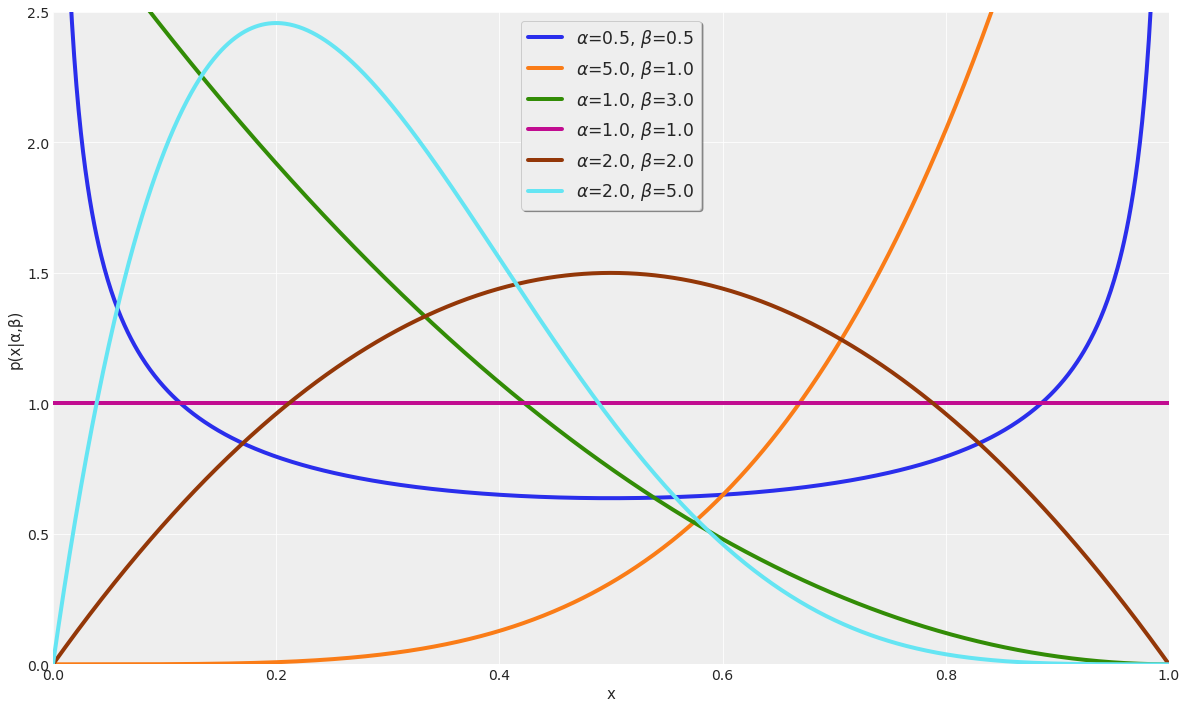

In [4]:
x = np.linspace(0.0, 1.0, 1000)
fig, ax = plt.subplots(figsize=(20,12))
f = lambda a, b : st.beta.pdf(x, a, b)
plot_pdf = lambda a, b : ax.plot(x, f(a,b), label=r'$\alpha$={0}, $\beta$={1}'.format(a,b), linewidth=4)
plot_pdf(0.5, 0.5)
plot_pdf(5.0, 1.0)
plot_pdf(1.0, 3.0)
plot_pdf(1.0, 1.0)
plot_pdf(2.0, 2.0)
plot_pdf(2.0, 5.0)
plt.legend(loc='upper center', frameon=True, shadow=True, fontsize = 'xx-large')
ax.set(xlim=[0,1], ylim=[0,2.5], xlabel='x', ylabel='p(x|α,β)')
plt.show()

### 3.1.5 - Gamma

$$
p(x \mid \alpha, \beta) = \frac{\beta^{\alpha} \; x^{\alpha-1} \; e^{-\beta x} }{\Gamma{(\alpha)}}
$$

In [ ]:
x = np.linspace(0.0, 20.0, 1000)
fig, ax = plt.subplots(figsize=(20,12))
f = lambda a, b : st.gamma.pdf(x, a, scale=1.0/b)
plot_pdf = lambda a, b : ax.plot(x, f(a, b), label=r'$\alpha$={0}, $\beta$={1}'.format(a, b), linewidth=4)
plot_pdf(1.0, 0.5)
plot_pdf(2.0, 0.5)
plot_pdf(3.0, 1.0)
plot_pdf(7.5, 1.0)
plt.legend(loc='upper center', frameon=True, shadow=True, fontsize = 'xx-large')
ax.set(xlim=[0,20], ylim=[0,0.4], xlabel='x', ylabel='p(x|α,β)')
plt.show()

## 3.2 Discrete Distributions <a class="anchor" id="discrete-distributions"></a>

### 3.2.2 - Bernoulli


$$
p(x \mid p) = p^{x}(1-p)^{1-x}
$$

Where:  
$p \; \rightarrow$  Probability of success

In [ ]:
fig, ax = plt.subplots(figsize=(20,12))
f = lambda p : st.bernoulli.pmf(np.arange(st.bernoulli.ppf(0.01, p), st.bernoulli.ppf(0.99, p)), p)
plot_pmf = lambda p : ax.bar(np.arange(st.bernoulli.ppf(0.01, p), st.bernoulli.ppf(0.99, p)), f(p), width=0.2, label=r'p={0}'.format(p))
plot_pmf(0.1)
plot_pmf(0.2)
plot_pmf(0.5)
plot_pmf(0.95)
plt.legend(loc='upper left', frameon=True, shadow=True, fontsize = 'xx-large')
ax.set(xlim=[-1,1], ylim=[0,1], xlabel='x', ylabel='p(x|n,p)')
plt.show()

### 3.2.2 - Binomial


$$
p(x \mid n, p) = \binom{n}{x} \; p^{x}(1-p)^{n-x}
$$

Where:  
$n \; \rightarrow$  Number of independent events  
$p \; \rightarrow$  Probability of success

Binomial is sum of individual Bernoulli distributions

In [ ]:
n_events= 50
fig, ax = plt.subplots(figsize=(20,12))
f = lambda n, p : st.binom.pmf(np.arange(st.binom.ppf(0.01, n, p), st.binom.ppf(0.99, n, p)), n,p)
plot_pmf = lambda n, p : ax.bar(np.arange(st.binom.ppf(0.01, n, p), st.binom.ppf(0.99, n, p)), f(n, p), width=0.3, label=r'n={0}, p={1}'.format(n, p))
plot_pmf(n_events,0.1)
plot_pmf(n_events,0.2)
plot_pmf(n_events,0.5)
plot_pmf(n_events,0.95)
plt.legend(loc='upper center', frameon=True, shadow=True, fontsize = 'xx-large')
ax.set(xlim=[-1,n_events], ylim=[0,0.3], xlabel='x', ylabel='p(x|n,p)')
plt.show()

### 3.1.3 - Poisson Distribution

$$
p(x \mid \mu) = \frac{e^{-\mu} \; \mu^{x}}{x!}
$$

Where:  
$\mu \; \rightarrow$  Expected number of occurrences during the given interval ($\mu$ >= 0)

In [ ]:
fig, ax = plt.subplots(figsize=(20,12))
f = lambda mu : st.poisson.pmf(np.arange(st.poisson.ppf(0.01, mu), st.poisson.ppf(0.99, mu)), mu)
plot_pmf = lambda mu : ax.bar(np.arange(st.poisson.ppf(0.01, mu), st.poisson.ppf(0.99, mu)), f(mu), width=0.3, label=r'μ={0}'.format(mu))
plot_pmf(0.5)
plot_pmf(1)
plot_pmf(2)
plot_pmf(10)
plt.legend(loc='upper center', frameon=True, shadow=True, fontsize = 'xx-large')
ax.set(xlim=[-1,20], ylim=[0,0.7], xlabel='x', ylabel='p(x| μ)')
plt.show()

### 3.1.4 - Negative Binomial

$$
p(x \mid n, p) = \binom{x+n-1}{n-1} \; p^{n}(1-p)^{x}
$$

Where:  
$n \; \rightarrow$  Number of independent events  
$p \; \rightarrow$  Probability of success

In [ ]:
n_events= 10
fig, ax = plt.subplots(figsize=(20,12))
f = lambda n, p : st.nbinom.pmf(np.arange(st.nbinom.ppf(0.01, n, p), st.nbinom.ppf(0.99, n, p)), n,p)
plot_pmf = lambda n, p : ax.bar(np.arange(st.nbinom.ppf(0.01, n, p), st.nbinom.ppf(0.99, n, p)), f(n, p), width=0.3, label=r'n={0}, p={1}'.format(n, p))
plot_pmf(n_events,0.5)
plot_pmf(n_events,0.8)
plot_pmf(n_events,0.95)
plt.legend(loc='upper center', frameon=True, shadow=True, fontsize = 'xx-large')
ax.set(xlim=[-1,30], ylim=[0,0.7], xlabel='x', ylabel='p(x|n,p)')
plt.show()

## 4. Posterior Approximation - A glimpse into MCMC <a class="anchor" id="mcmc"></a>

- While convalescing from an illness in 1946, Stan Ulam was playing solitaire. It, then, occurred to him to try to compute the chances that a particular solitaire laid out with 52 cards would come out successfully (Eckhard, 1987). After attempting exhaustive combinatorial calculations, he decided to go for the more practical approach of laying out several solitaires at random and then observing and counting the number of successful plays. This idea of selecting a statistical sample to approximate a hard combinatorial problem by a much simpler problem is at the heart of modern Monte Carlo simulation.
- MCMC algorithms typically require the design of proposal mechanisms to generate candidate hypotheses
- MCMC techniques are often applied to solve integration and optimisation problems in large dimensional spaces.

## MCMC Heroes
<TABLE border="1">
<tr>
    <th align="center">Stan Ulam</th>
    <th align="center">John von Neumann</th>
    <th align="center">Enrico Fermi</th>
</tr>
<tr>
    <th><img src="imgs_prez/Stanislaw_Ulam.tif.jpg" width="360" height="180" align="center"/></th>
    <th><img src="imgs_prez/440px-JohnvonNeumann-LosAlamos.gif" width="360" height="180" align="center"/></th>
    <th><img src="imgs_prez/440px-Enrico_Fermi_1943-49.jpg" width="360" height="180" align="center"/></th>
</tr>
</TABLE>

 **Source**: An Introduction to MCMC for Machine Learning

## Rejection Sampling

Draw samples from a complicated distribution $P(x)$ where sampling directly is hard.  

Use a proposal distribution $Q(x)$ that is easier to sample from, where $Q(x)$ needs to envelope $P(x)$ ( $k \: Q(x) \: > \: P(x)$) for all x.

**P(x)** $\rightarrow $ Initial Distribution  
**Q(x)** $\rightarrow $ Proposal Distribution 

In [ ]:
import numpy as np
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt

proposal_loc = 50
proposal_scale = 30
sns.set()
def p(x):
    return st.norm.pdf(x, loc=30, scale=10) \
           + st.norm.pdf(x, loc=80, scale=20) \
          # + st.norm.pdf(x, loc=150, scale=10)
def q(x):
    return st.norm.pdf(x, loc=proposal_loc, scale=proposal_scale)

In [ ]:
def rejection_sampling(iter=1000):
    samples = []

    for i in range(iter):
        z = np.random.normal(proposal_loc, proposal_scale)
        u = np.random.uniform(0, k*q(z))

        if u <= p(z):
            samples.append(z)

    return np.array(samples)

In [ ]:
p_init = -50
p_end = 200
x = np.arange(p_init, p_end)
k = max(p(x) / q(x))

In [ ]:
plt.rcParams["figure.figsize"] = (15,8)
plt.plot(x, p(x))
plt.plot(x, k*q(x),'g')
plt.show()

In [ ]:
s = rejection_sampling(iter=100000)
sns.distplot(s)

## Drawbacks
- Needs to have a good fit between $Q(x)$ and $P(x)$ 
- May be hard to choose $Q(x)$ for complex distributions  
- Lot's of time wasted in rejecting points out of $P(x)$

### The Monte Carlo principle

$$
p_{N}(x)=\frac{1}{N}\sum_{i=1}^{N} \delta_{x}^{(i)}(x)
$$

Approximate integrals (or very large sums) $I(f)$ with tractable sums $I_{N}(f)$


$$
I_{N}(f)=\frac{1}{N}\sum_{i=1}^{N} f(x^{(i)}) \xrightarrow[\inf]{\text{a.s.}}I(f) = \int_{x} f(x)p(x)d(x)
$$

- Main idea: 
    - generating samples $x_{i}$ while exploring the state space _**X**_ using a
Markov chain mechanism $\rightarrow$ spend more time in most important (high probable) regions

### Metropolis-Hastings

### Hamiltonian Monte Carlo

 **Source**: https://colindcarroll.com/2019/04/11/hamiltonian-monte-carlo-from-scratch/

In [ ]:
https://colindcarroll.com/2019/04/11/hamiltonian-monte-carlo-from-scratch/

## Demo - Metropolis- Hastings

[Chi Feng - MCMC Galery](https://chi-feng.github.io/mcmc-demo/app.html)

## 5. Quick Example in PyMC3  <a class="anchor" id="example"></a>

## Sources <a class="anchor" id="sources"></a>

1. [Michael Betancourt - Probabilistic Modeling and Statistical Inference](https://betanalpha.github.io/assets/case_studies/modeling_and_inference.html)  
2. [Michael Betancourt - Probabilistic Building Blocks](https://betanalpha.github.io/assets/case_studies/probability_densities.html)  
3. [Michael Betancourt - Markov Chain Monte Carlo in Practice](https://betanalpha.github.io/assets/case_studies/markov_chain_monte_carlo.html)  
4. [Aerin Kim - Bayesian Inference — Intuition and Example](https://towardsdatascience.com/bayesian-inference-intuition-and-example-148fd8fb95d6)
5. [AllenDowney - ThinkBayes2](https://github.com/AllenDowney/ThinkBayes2)
6. [Andrew Gelman - Bayesian Data Analysis](http://www.stat.columbia.edu/~gelman/book/)  
7. [Colin Carroll - imcmc](https://github.com/ColCarroll/imcmc)
8. [Andrieu, Freitas - An Introduction to MCMC for Machine Learning](https://www.cs.ubc.ca/~arnaud/andrieu_defreitas_doucet_jordan_intromontecarlomachinelearning.pdf)  
9. [Eric Ma - An Introduction to Probability and Computational Bayesian Statistics](https://ericmjl.github.io/essays-on-data-science/machine-learning/computational-bayesian-stats/)  
10. [Agustinus Kristiadi's Blog - Rejection Sampling](https://wiseodd.github.io/techblog/2015/10/21/rejection-sampling/)  
11. [Thomas Wiecki - MCMC sampling for dummies](https://twiecki.io/blog/2015/11/10/mcmc-sampling/)  
12. [Chi Feng - MCMC Galery](https://chi-feng.github.io/mcmc-demo/app.html)  
13. [Iain Murray - Introduction to MCMC for Deep Learning](https://www.youtube.com/watch?v=Em6mQQy4wYA&t=1974s)

## Nando MCMC Videos
- Video 1: https://youtu.be/TNZk8lo4e-Q
- Video 2: https://youtu.be/sK3cg15g8FI